# Analyse du Taux d'Attrition - HumanForYou

## Projet d'Intelligence Artificielle

**Contexte** : L'entreprise pharmaceutique HumanForYou (basée en Inde, ~4000 employés) connaît un taux de rotation d'environ 15% par an. La direction souhaite identifier les facteurs influençant ce taux et proposer des pistes d'amélioration pour fidéliser les employés.



### 1. Préparation de l'environnement

In [2]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob  
import warnings
warnings.filterwarnings("ignore")

# ML Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

### 2. Loading and Exploring the Housing Data

In [3]:

#import files
base_path = r"C:\Users\ldxd1\Downloads\projet AI"

# Dictionnaire pour stocker tous les DataFrames
dfs = {}

for file_path in glob.glob(os.path.join(base_path, "*.csv")):
    file_name = os.path.basename(file_path)   # ex : 'employee_survey_data.csv'
    key = os.path.splitext(file_name)[0]      # ex : 'employee_survey_data'
    
    dfs[key] = pd.read_csv(file_path)
    print(f"Chargé : {file_name} → dfs['{key}']")


Chargé : employee_survey_data.csv → dfs['employee_survey_data']
Chargé : general_data.csv → dfs['general_data']
Chargé : in_time.csv → dfs['in_time']
Chargé : manager_survey_data.csv → dfs['manager_survey_data']
Chargé : out_time.csv → dfs['out_time']


### 3. Understanding the Data

In [4]:
# Check data types and missing values
for name in ["employee_survey_data", "manager_survey_data", "general_data", "in_time", "out_time"]:
    print(f"\n{name} :\n")
    dfs[name].info()

# General Data (optionnel car fichier trop volumineux)



employee_survey_data :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 137.9 KB

manager_survey_data :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   EmployeeID         4410 non-null   int64
 1   JobInvolvement     4410 non-null   int64
 2   PerformanceRating  4410 non-null   int64
dtypes: int64(3)
memory usage: 103.5 KB

general_data :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Da

In [5]:
# Summary statistics
for name in ["employee_survey_data", "manager_survey_data"]:
    print(f"\n{name} :\n")
    print(dfs[name].describe())
    


employee_survey_data :

        EmployeeID  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
count  4410.000000              4385.000000      4390.000000      4372.000000
mean   2205.500000                 2.723603         2.728246         2.761436
std    1273.201673                 1.092756         1.101253         0.706245
min       1.000000                 1.000000         1.000000         1.000000
25%    1103.250000                 2.000000         2.000000         2.000000
50%    2205.500000                 3.000000         3.000000         3.000000
75%    3307.750000                 4.000000         4.000000         3.000000
max    4410.000000                 4.000000         4.000000         4.000000

manager_survey_data :

        EmployeeID  JobInvolvement  PerformanceRating
count  4410.000000     4410.000000        4410.000000
mean   2205.500000        2.729932           3.153741
std    1273.201673        0.711400           0.360742
min       1.000000        1.00000

### 4. Fusion des Datasets

In [6]:

general_data      = dfs["general_data"]
employee_survey   = dfs["employee_survey_data"]
manager_survey    = dfs["manager_survey_data"]


df = None  # dataset final

if general_data is not None:
    # Standardiser la clé de jointure
    if "EmployeeId" in general_data.columns:
        general_data = general_data.rename(columns={"EmployeeId": "EmployeeID"})
    
    df = general_data.copy()
    
    if employee_survey is not None:
        df = df.merge(employee_survey, on="EmployeeID", how="left")
        print("Fusionné avec employee_survey_data")
    
    if manager_survey is not None:
        df = df.merge(manager_survey, on="EmployeeID", how="left")
        print("Fusionné avec manager_survey_data")
    
    print(f"\nDataset fusionné: {df.shape[0]} lignes × {df.shape[1]} colonnes")


else:
    # Cas où on n'a pas general_data : on fusionne juste les surveys si possibles
    if (employee_survey is not None) and (manager_survey is not None):
        df = employee_survey.merge(manager_survey, on="EmployeeID", how="outer")
        print(f"\n Dataset partiel (surveys uniquement): {df.shape[0]} lignes × {df.shape[1]} colonnes")
        print("Sans general_data, la variable cible (Attrition) risque de manquer.")
    else:
        print("Impossible de créer un dataset fusionné (données insuffisantes).")


print(df.info())

Fusionné avec employee_survey_data
Fusionné avec manager_survey_data

Dataset fusionné: 4410 lignes × 29 colonnes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus     

### 5. Handling Missing Values

In [14]:
# show missing values
print(df.isnull().sum())

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
dtype: int64


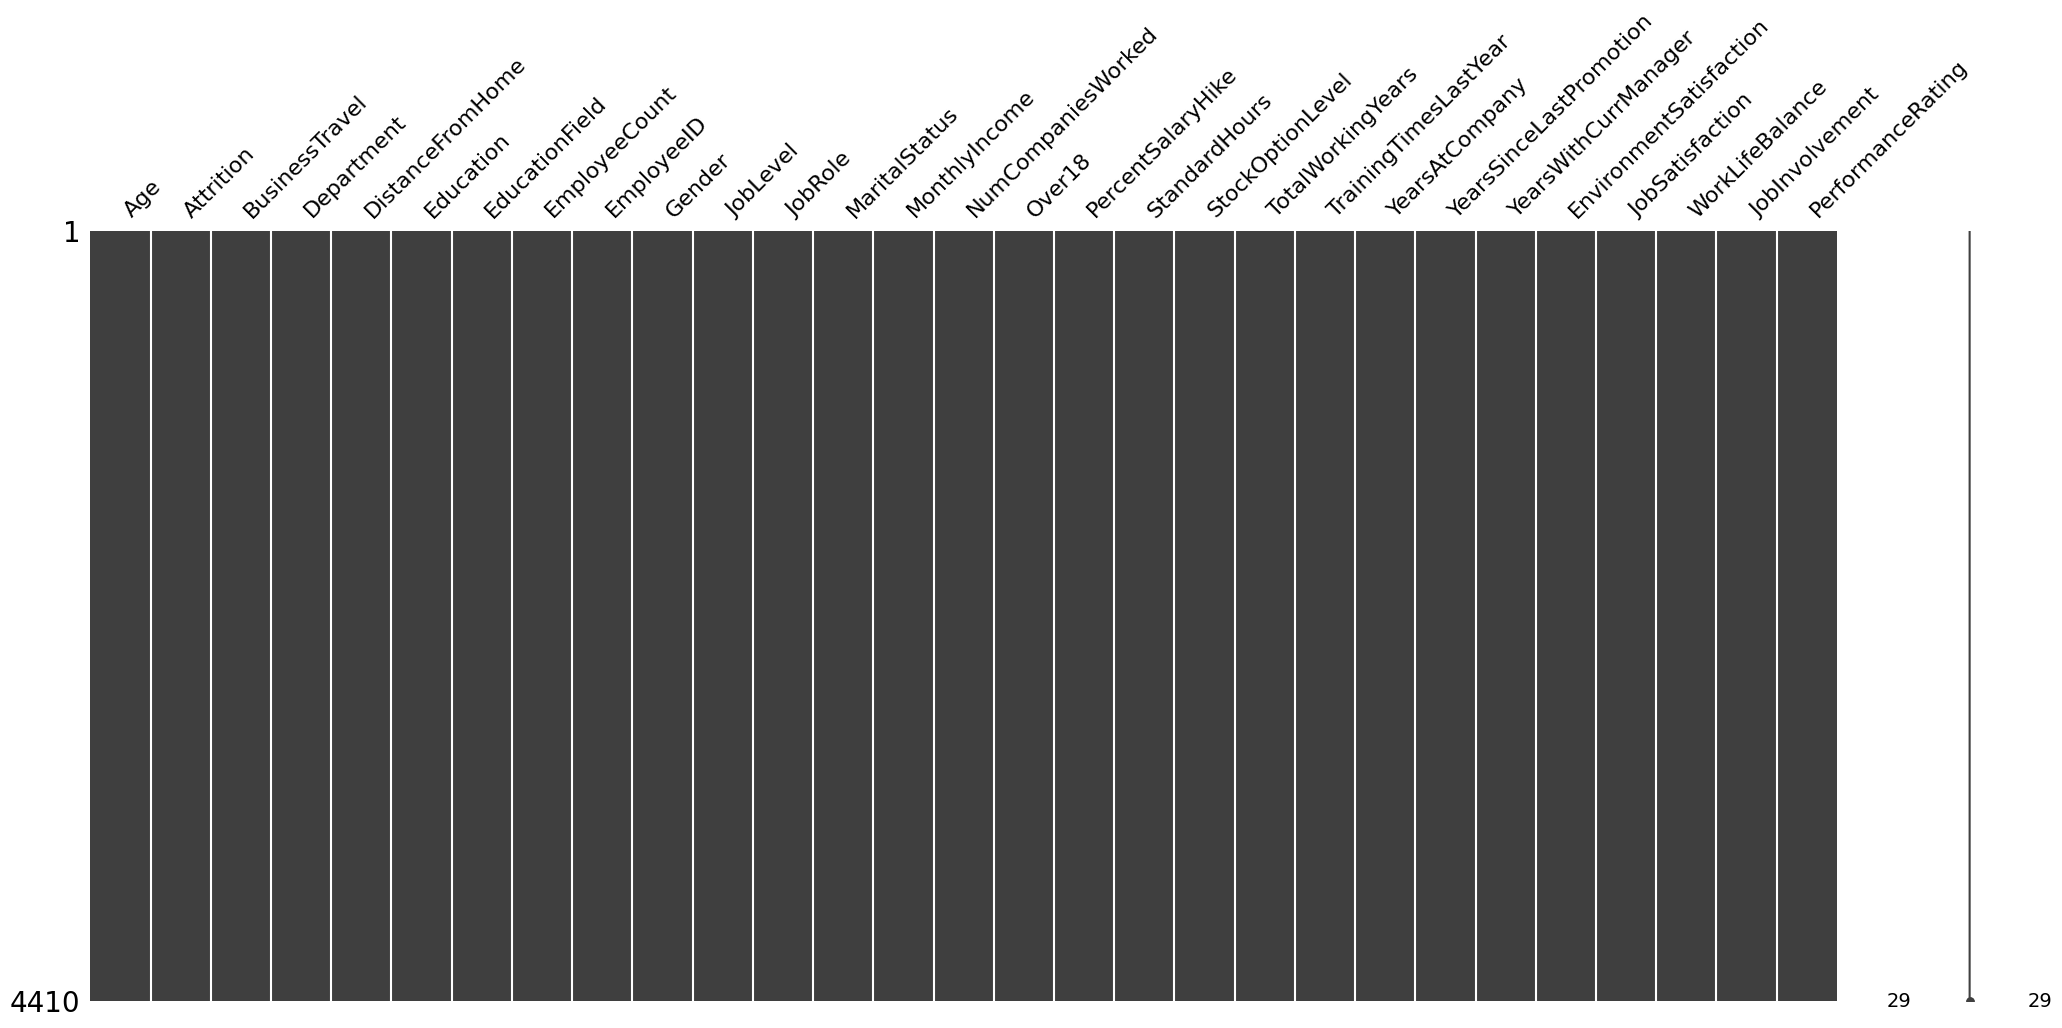

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
dtype: int64

In [15]:

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize missing data
msno.matrix(df)
plt.show()

# Impute missing values
# For numerical columns, use median imputation
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median())

# For categorical columns, use mode imputation
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

# Verify that there are no more missing values
df.isnull().sum()


### 6. Univariate Analysis


In [16]:
"""
import seaborn as sns
import matplotlib.pyplot as plt

# Définir les colonnes numériques et catégorielles
numerical_columns   = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Univariate analysis for numerical features
for column in numerical_columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=column, kde=True)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()
    plt.show()

# Univariate analysis for categorical features
for column in categorical_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=column)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
"""

"\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Définir les colonnes numériques et catégorielles\nnumerical_columns   = df.select_dtypes(include=['float64', 'int64']).columns\ncategorical_columns = df.select_dtypes(include=['object']).columns\n\n# Univariate analysis for numerical features\nfor column in numerical_columns:\n    plt.figure(figsize=(10, 4))\n    sns.histplot(data=df, x=column, kde=True)\n    plt.title(f'Distribution of {column}')\n    plt.tight_layout()\n    plt.show()\n\n# Univariate analysis for categorical features\nfor column in categorical_columns:\n    plt.figure(figsize=(10, 4))\n    sns.countplot(data=df, x=column)\n    plt.title(f'Distribution of {column}')\n    plt.xticks(rotation=45)\n    plt.tight_layout()\n    plt.show()\n"

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify numerical and categorical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
print('numerical_columns : ', numerical_columns)
print('categorical columns : ', categorical_columns)

numerical_columns :  Index(['Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
       'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating'],
      dtype='object')
categorical columns :  Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18'],
      dtype='object')


### 6. Exploratory Data Analysis

In [23]:
# put remaining continuous features in a list
continuous_features = ['DistanceFromHome','MonthlyIncome','TotalWorkingYears','TrainingTimesLastYear', 'YearsAtCompany',
'YearsSinceLastPromotion','PercentSalaryHike','YearsWithCurrManager','mean_time']

In [24]:
df_eda = df.copy()

In [32]:
# Age - Lets create buckets/bins of 10 years
df_eda.Age = pd.cut(df.Age, range(10, 70, 10))

def make_plot(feature_name, x_ticks = 'not_needed'):
    """This function is used to generate a countplot for the passed input feature present
    in df_eda dataframe. Appropriate plot title, xlabel, ylabel, lengend are also added.
    The last part of this function also places a percentage value over each bar of
    generated countplot.

    Args:
        feature_name: the feature name in string format.
        x_ticks: default value is 'not_needed'. If you want to customize xticks then pass
                 a list containing new xticks.

    """
    # Initialize a figure
    plt.figure(figsize = (18,7))
    
    # Generate a countplot for the passed feature_name
    ax = sns.countplot(x=feature_name, hue='Attrition', data=df_eda, palette='Set2')
    
    # Check if custom x_tick is needed or not
    if x_ticks != 'not_needed':
        # Generate index of xticks
        ticks_index = [i for i in range(len(x_ticks))]
        
        # set new xticks by passing ticks_index and custom xtick labels 
        ax.set(xticks=ticks_index, xticklabels=x_ticks)
        
    # set title, xlabel, ylabel, legend
    plt.xlabel(feature_name,fontsize  = 14)
    plt.ylabel('Employee Count',fontsize  = 14)
    plt.title('{} vs Attrition'.format(feature_name), fontsize = 18)
    plt.legend(fontsize = 14)

    # From axis.patches get bar lengths
    get_bars = ax.patches
    half_bar_length = int(len(get_bars)/2)
    bar_left = get_bars[:half_bar_length]
    bar_right = get_bars[half_bar_length:]
    
    # Place %employees on top of each bar
    for L, R in zip(bar_left, bar_right):
        left_height = L.get_height()
        right_height = R.get_height()
        length_total = left_height + right_height

        # place calculated employee percentage on top of each bar
        ax.text(L.get_x() + L.get_width()/2., left_height + 30, '{0:.0%}'.format(left_height/length_total), ha="center")
        ax.text(R.get_x() + R.get_width()/2., right_height + 30, '{0:.0%}'.format(right_height/length_total), ha="center")


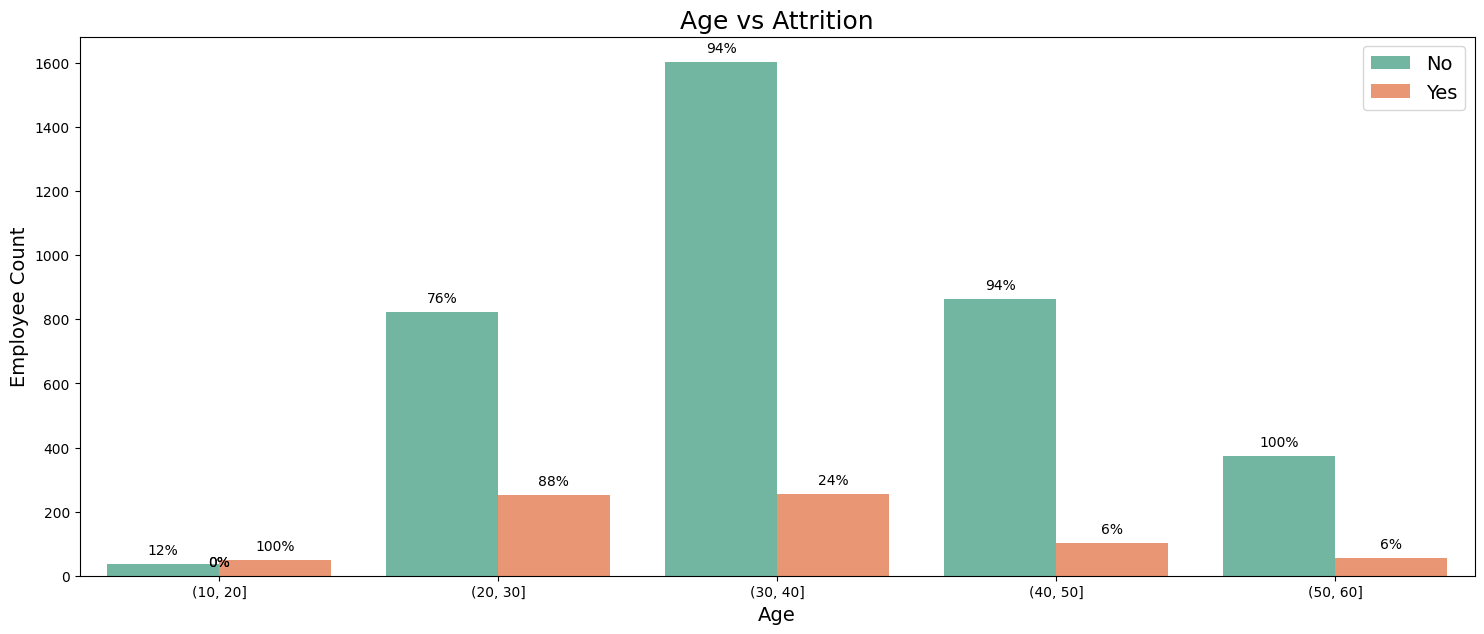

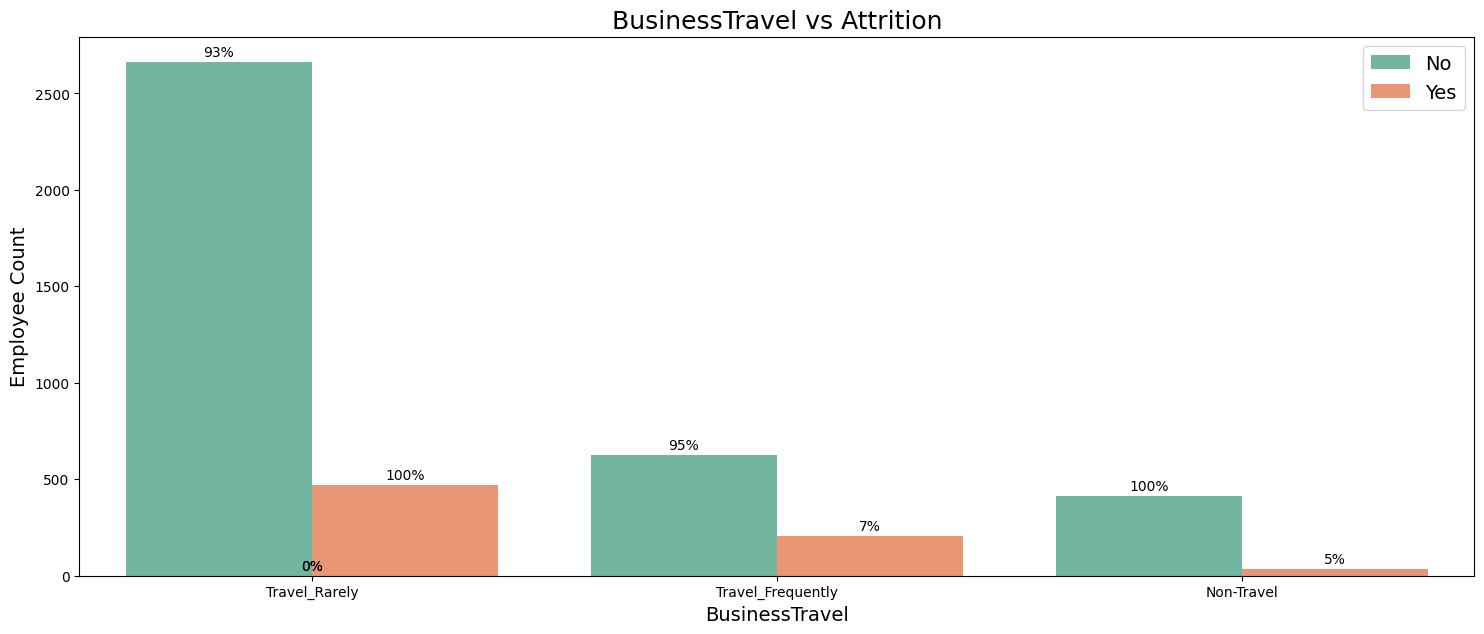

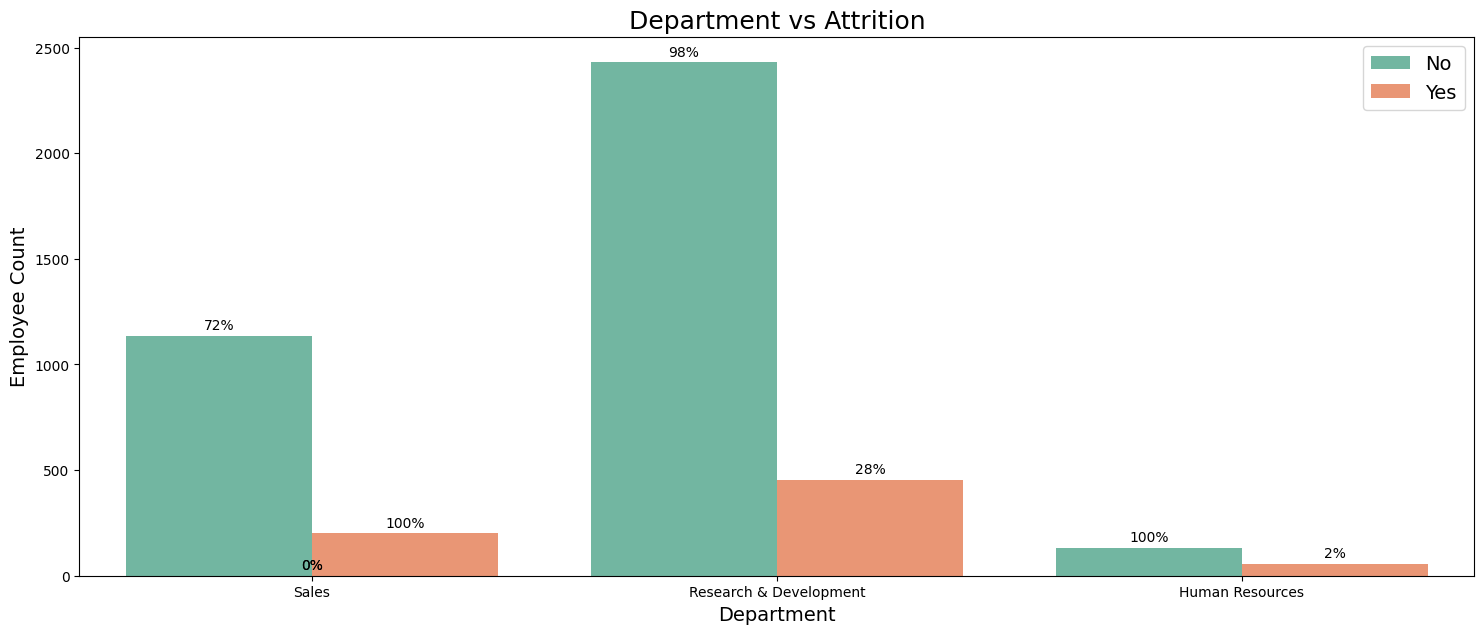

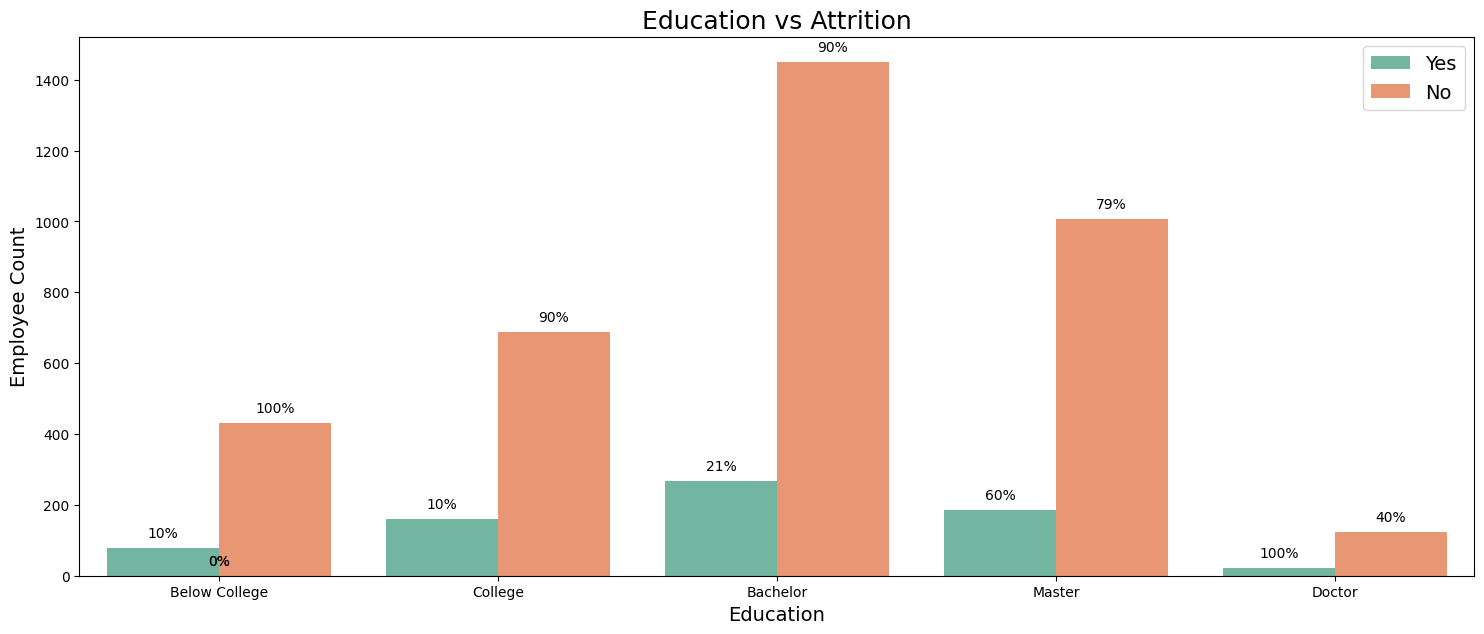

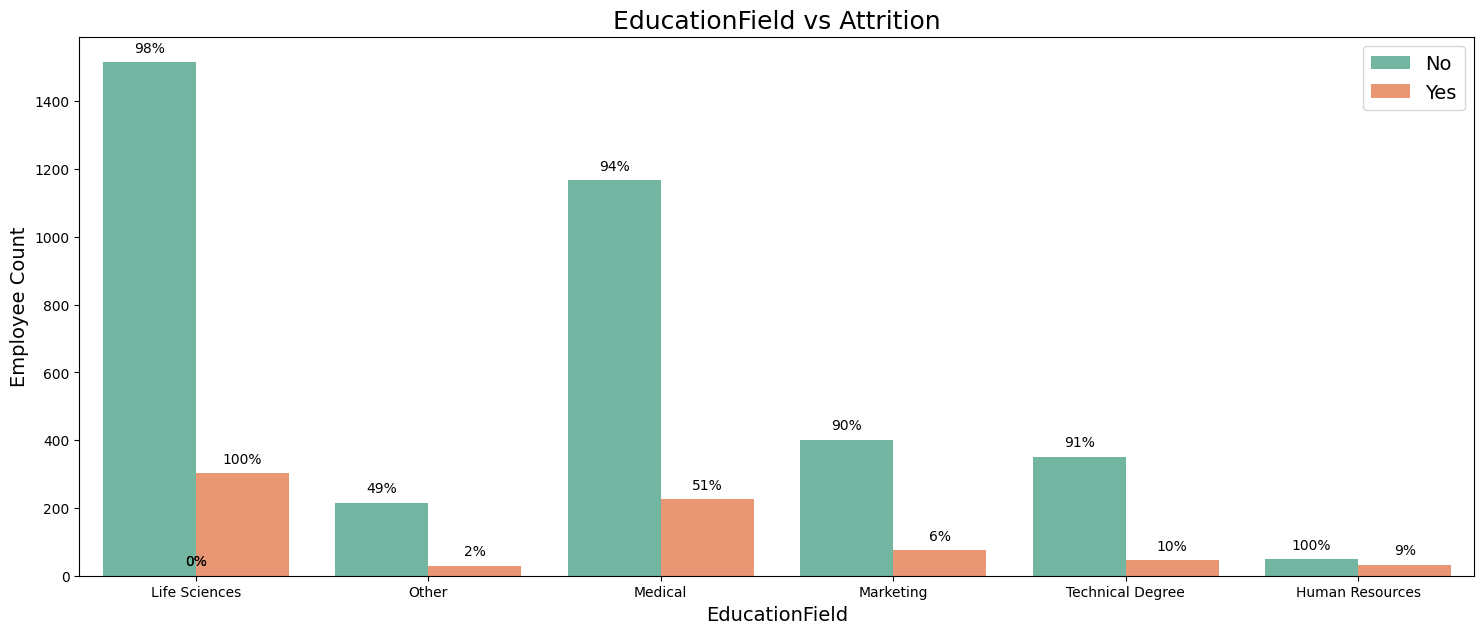

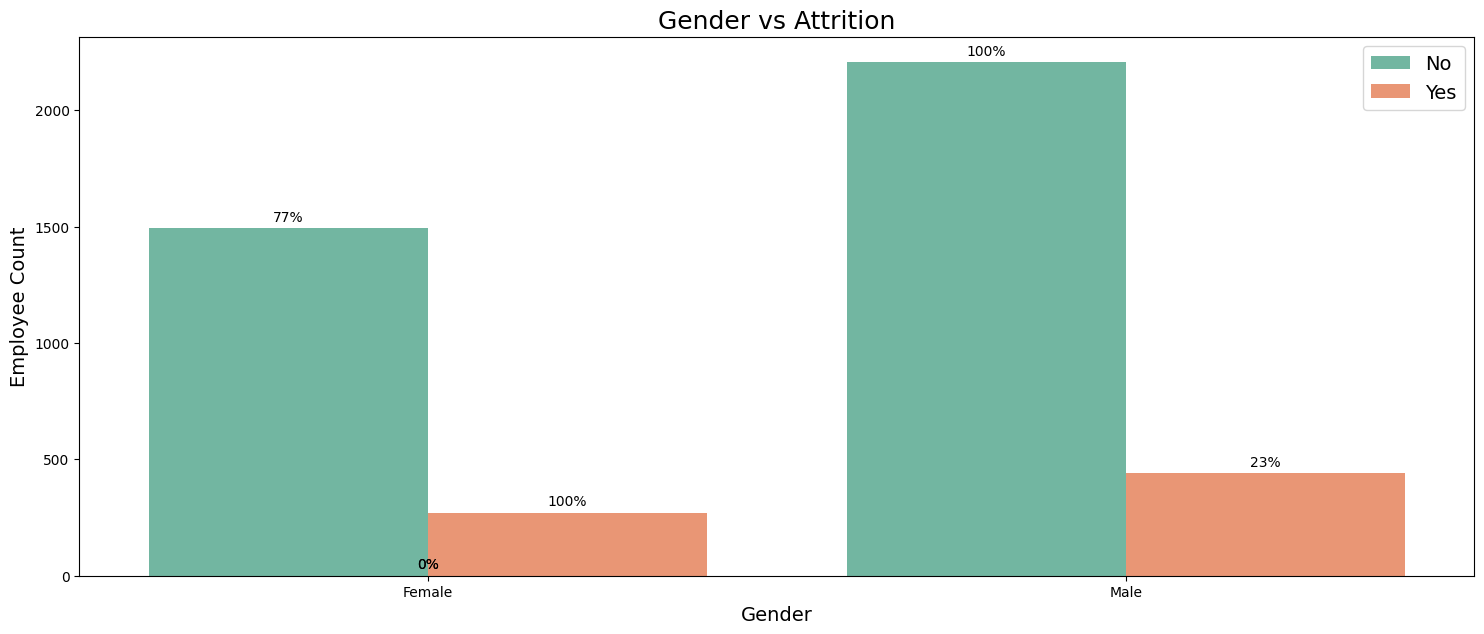

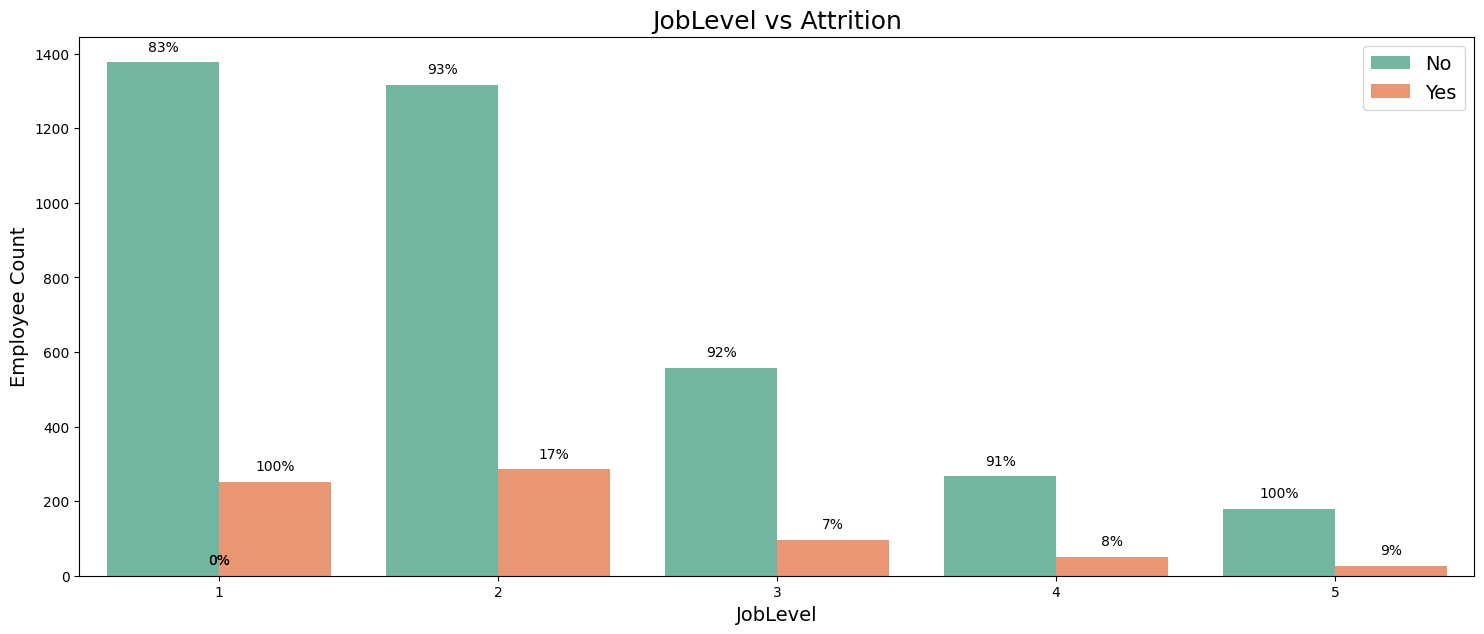

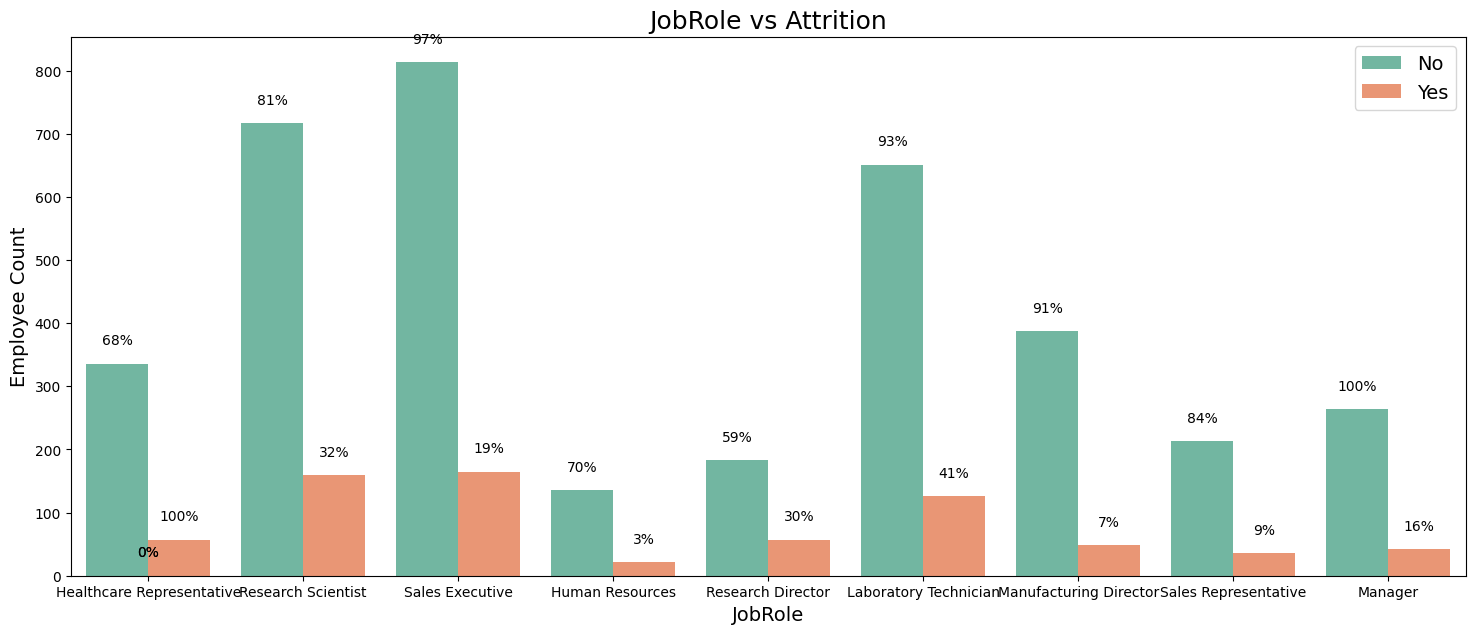

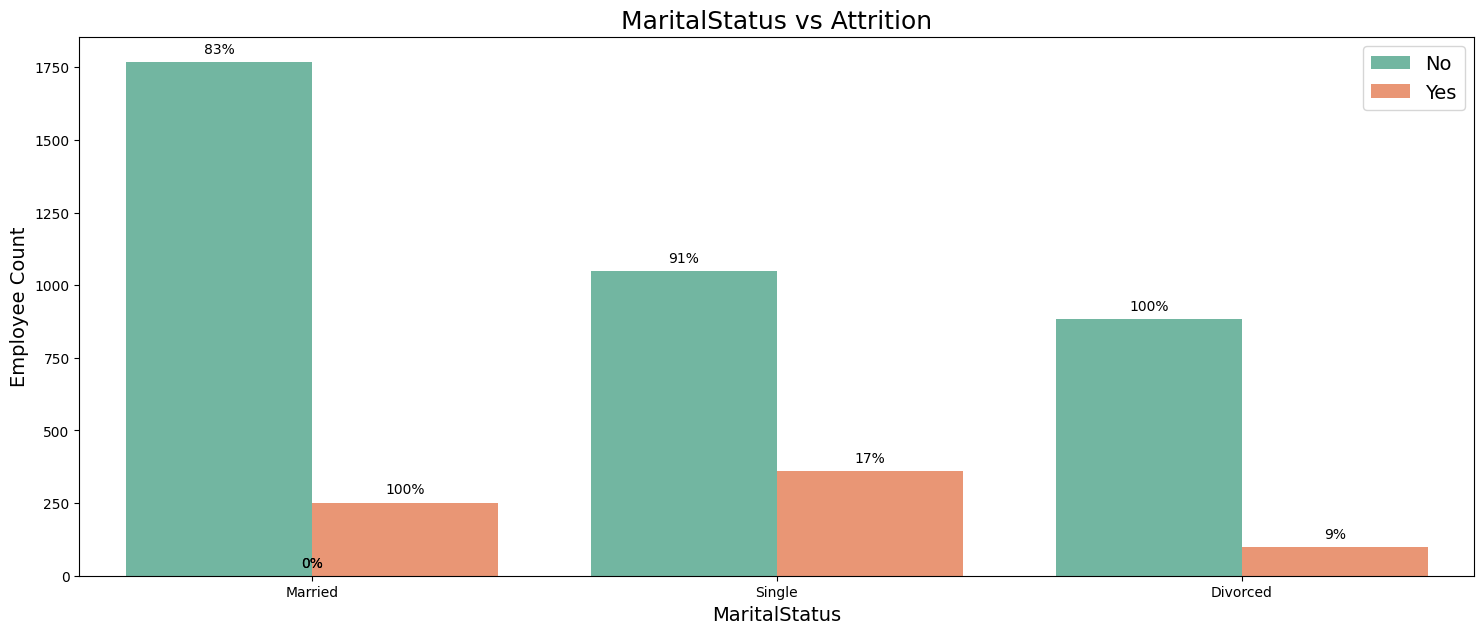

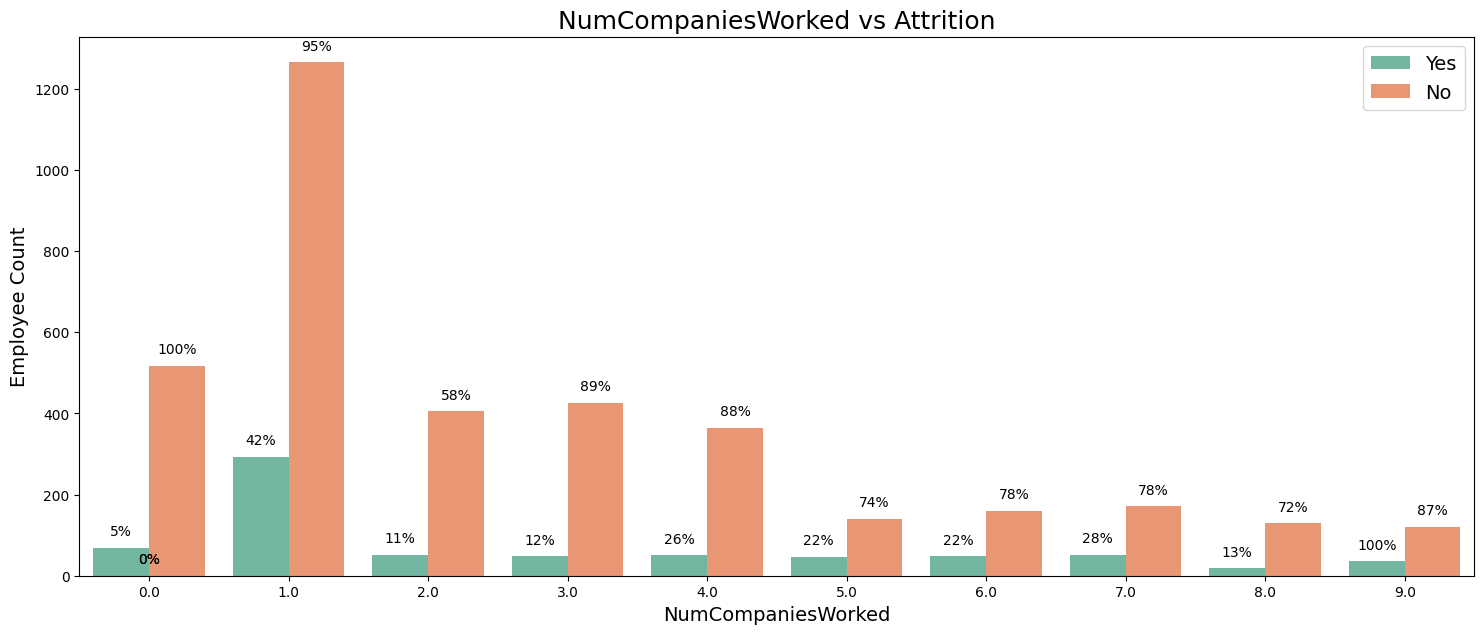

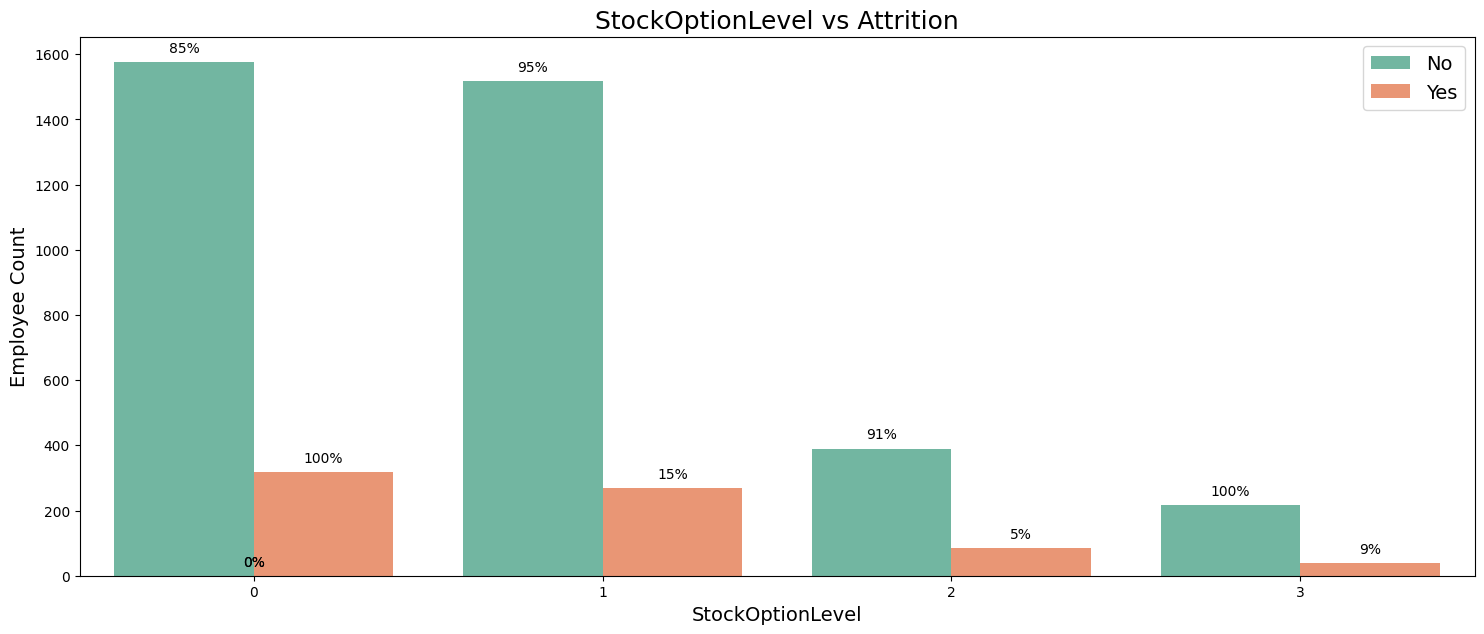

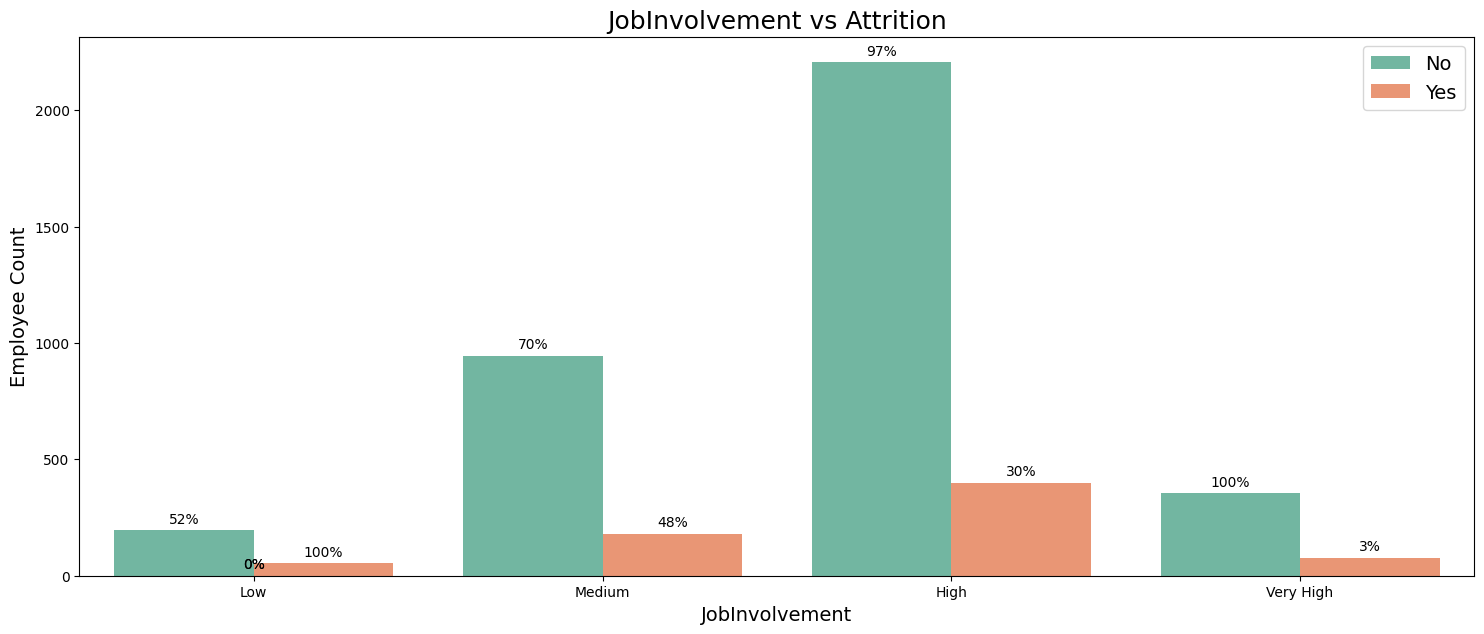

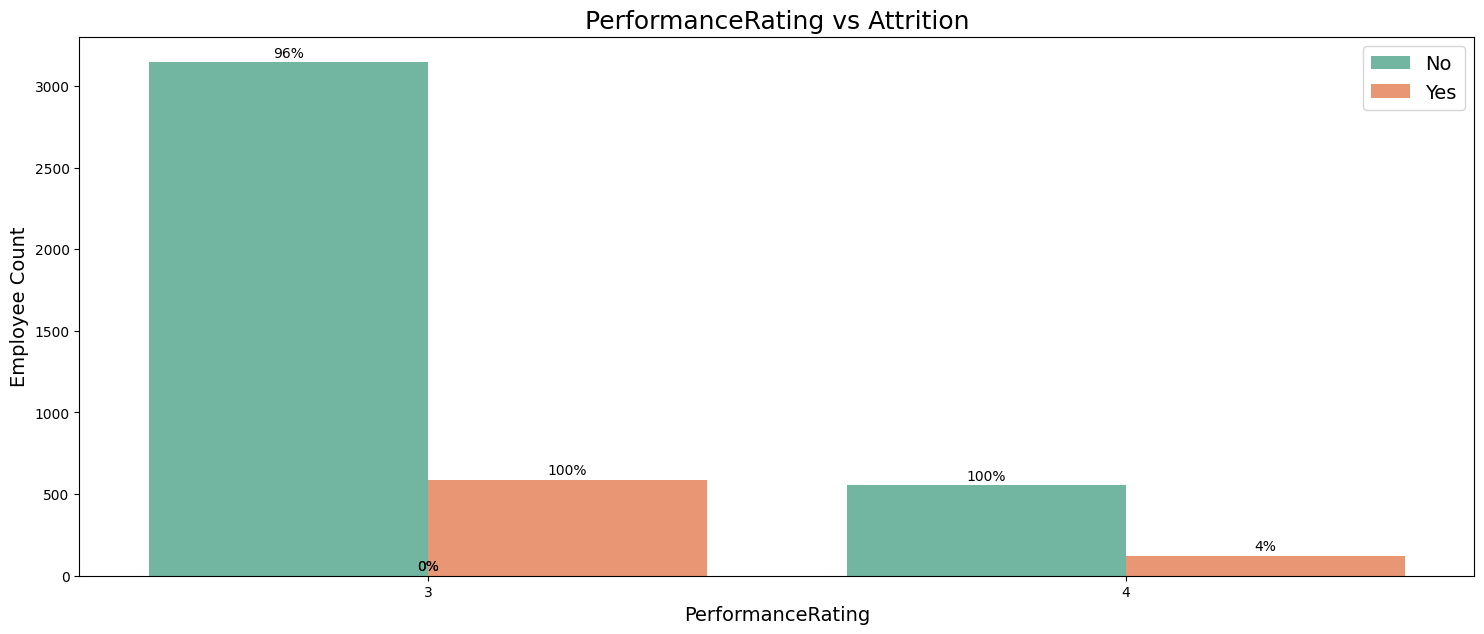

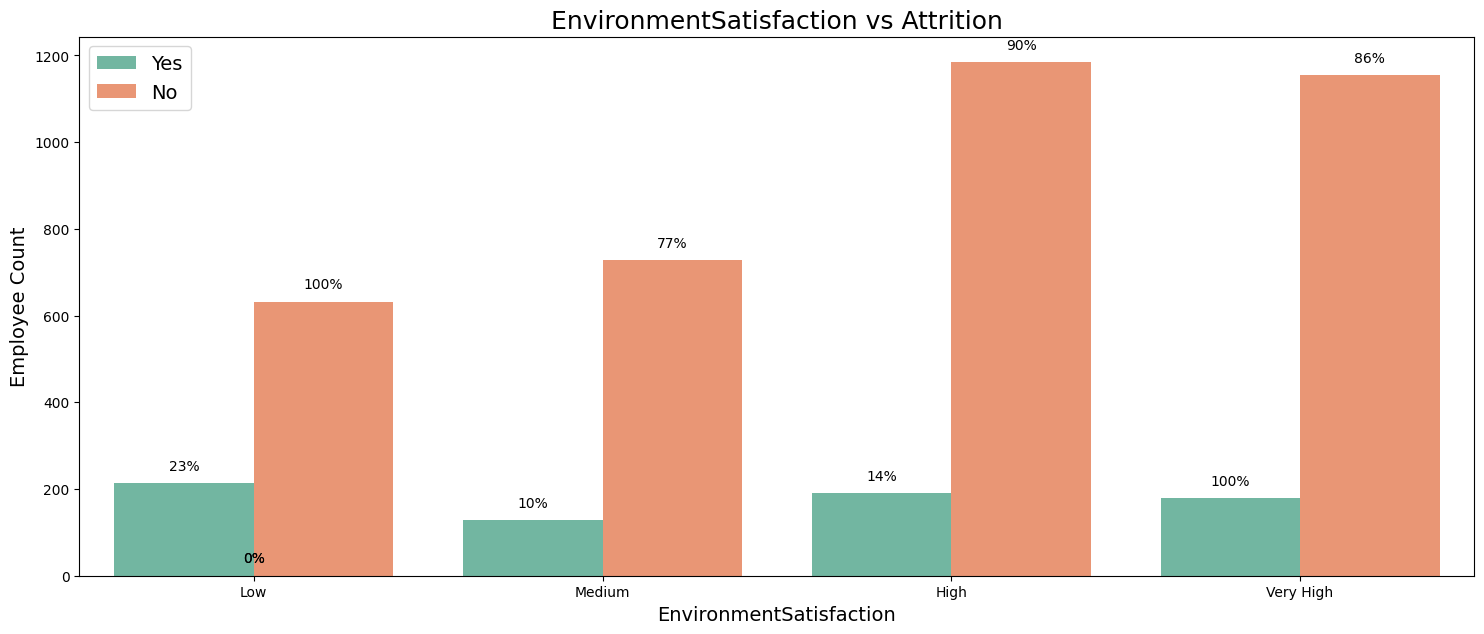

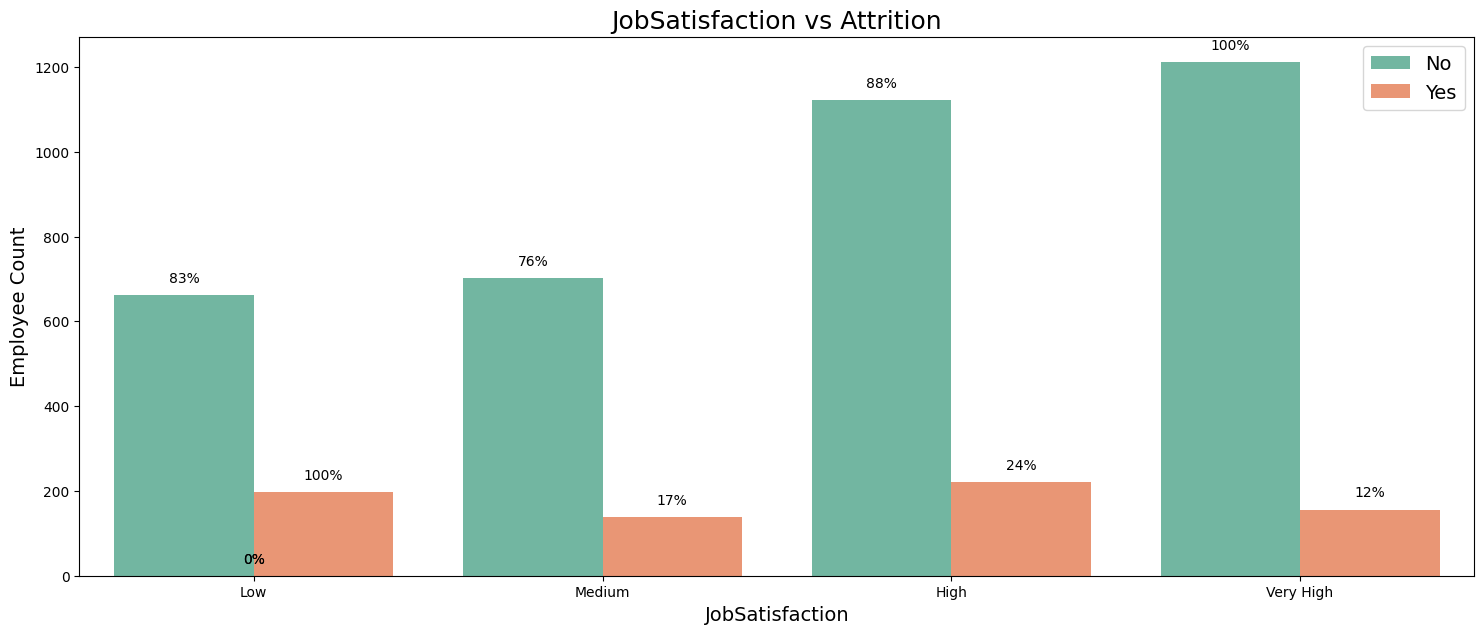

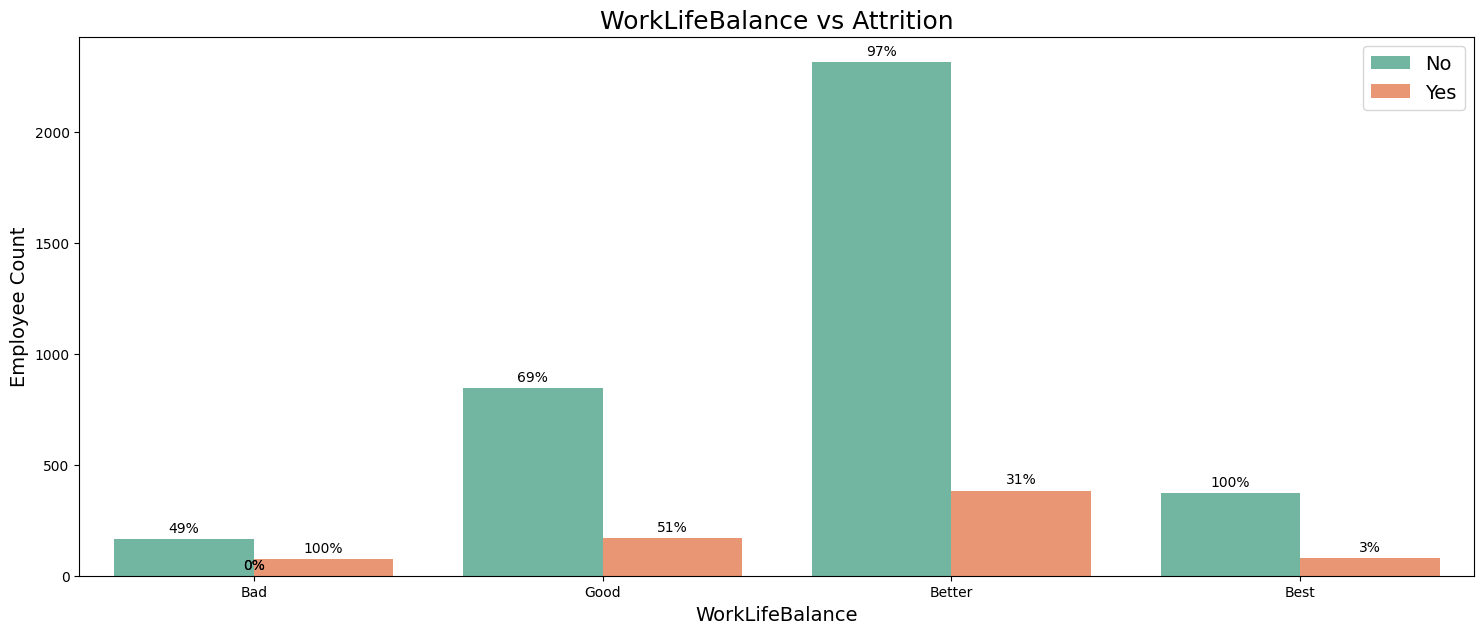

In [ ]:
for name in ['Age','BusinessTravel', 'Department','Education','EducationField','Gender',
             'JobLevel','JobRole','MaritalStatus','NumCompaniesWorked','StockOptionLevel',
             'JobInvolvement','PerformanceRating','EnvironmentSatisfaction','JobSatisfaction',
             'WorkLifeBalance']:
    make_plot(name)

# Age
make_plot('Age')

# BusinessTravel
make_plot('BusinessTravel')

# Department
make_plot('Department')

# Education
make_plot('Education',['Below College','College','Bachelor','Master','Doctor'])

# EducationField
make_plot('EducationField')

# Gender 
make_plot('Gender')

# JobLevel
make_plot('JobLevel')

# JobRole
make_plot('JobRole')

# MaritalStatus
make_plot('MaritalStatus')

# NumCompaniesWorked
make_plot('NumCompaniesWorked')

# StockOptionLevel
make_plot('StockOptionLevel')

# JobInvolvement
make_plot('JobInvolvement',['Low','Medium','High','Very High']) 

# PerformanceRating 
make_plot('PerformanceRating')

# EnvironmentSatisfaction
make_plot('EnvironmentSatisfaction',['Low','Medium','High','Very High']) 

# JobSatisfaction
make_plot('JobSatisfaction',['Low','Medium','High','Very High']) 

# WorkLifeBalance
make_plot('WorkLifeBalance',['Bad','Good','Better','Best']) 

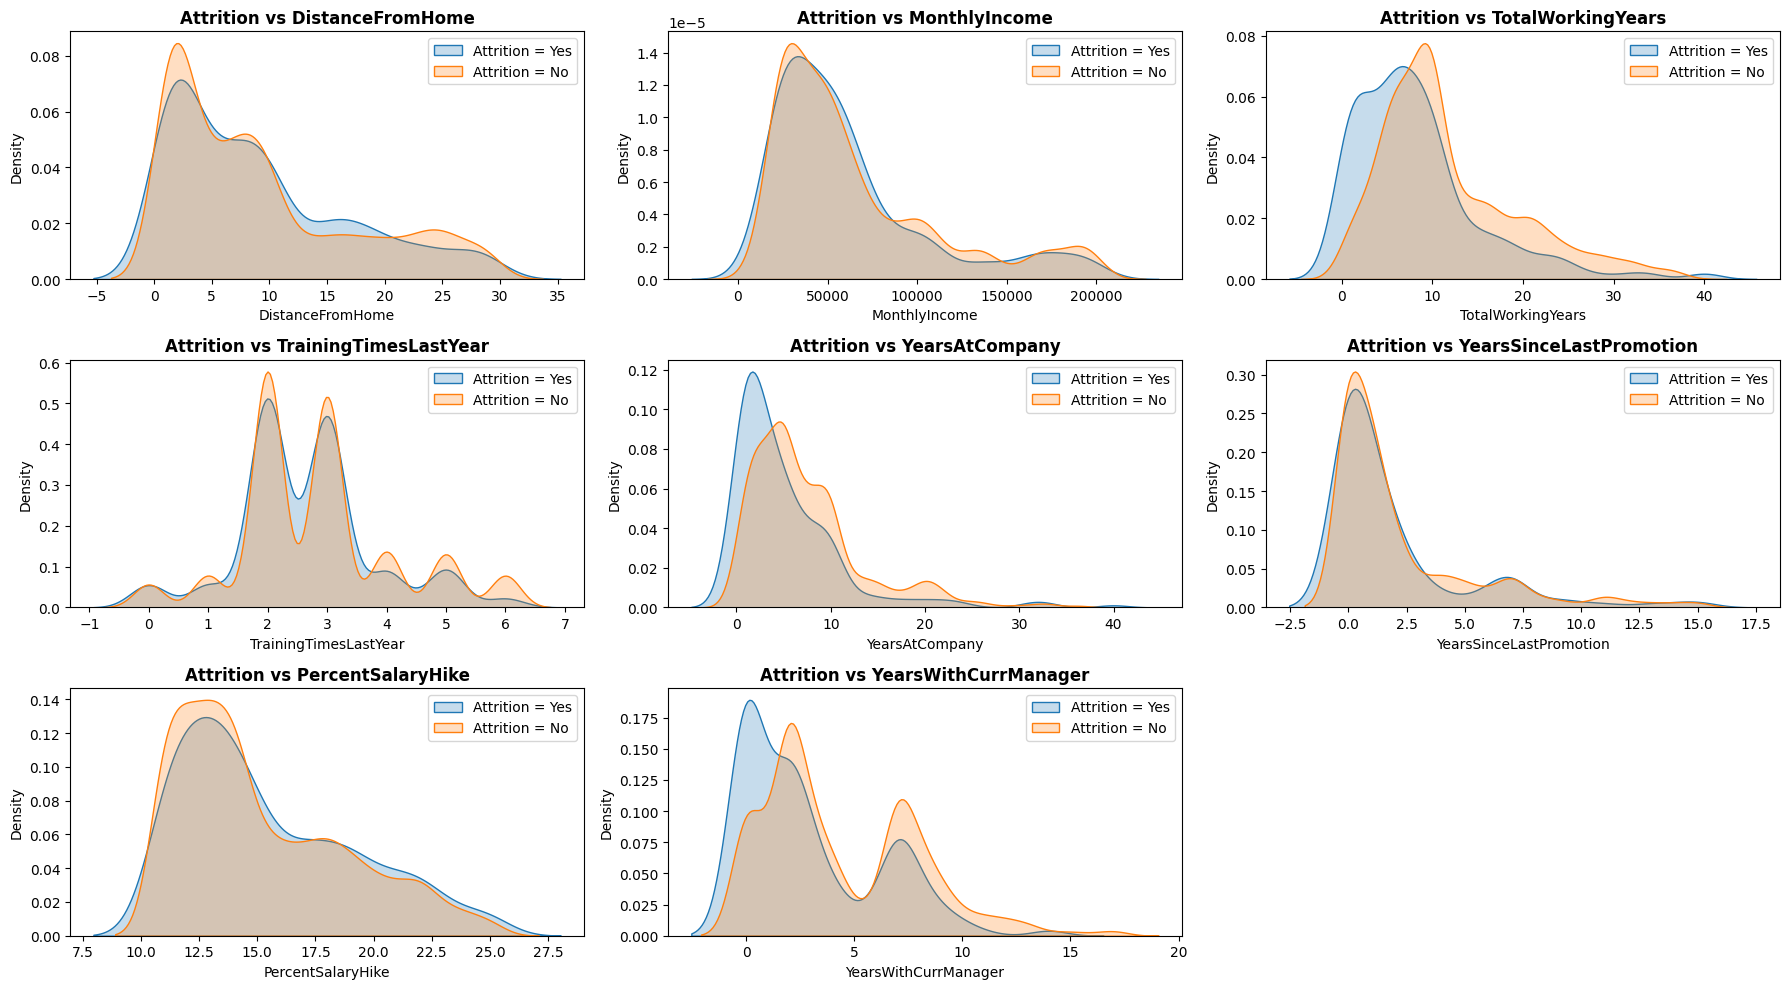

In [35]:
continuous_features = [
    'DistanceFromHome','MonthlyIncome','TotalWorkingYears',
    'TrainingTimesLastYear','YearsAtCompany',
    'YearsSinceLastPromotion','PercentSalaryHike',
    'YearsWithCurrManager'
]  # 8 features seulement

fig,ax =  plt.subplots(3,3, figsize = (18,10))  # tu peux garder 3x3, il y aura un plot vide

index = 0
for i in range(3):
    for j in range(3):
        if index >= len(continuous_features):
            ax[i][j].axis("off")   # désactiver les cases en trop
            continue

        feature = continuous_features[index]
        ax[i][j].set_title(f'Attrition vs {feature}', fontsize=12, fontweight='bold')

        sns.kdeplot(
            df_eda[df_eda['Attrition']=='Yes'][feature],
            shade=True, label='Attrition = Yes', ax=ax[i][j]
        )
        sns.kdeplot(
            df_eda[df_eda['Attrition']=='No'][feature],
            shade=True, label='Attrition = No', ax=ax[i][j]
        )
        ax[i][j].legend()
        index += 1

plt.tight_layout()
plt.show()
